### Boston Half Marathon 2025 womens results analysis
#### This notebook analyzes official data downloaded from the website.

In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sn

#### Helper functions 
1. to parse time and convert into minutes
2. to parse age from age divisions

In [164]:
def parse_time(x):
    parts = x.split(':')
    try:
        #if time is H:M:S
        if len(parts) == 3:
            h = int(parts[0])
            m = int(parts[1])
            s = int(parts[2])
            total_min = h * 60 + m + s/60
        #if time is M:S and decimal seconds like 19:42.0
        elif len(parts) == 2:
            m = int(parts[0])
            s = int(float(parts[1]))
            total_min = m + s/60
        #if neither pattern fits error and add NA
        else:
                raise ValueError
        
    except (ValueError, IndexError):
        total_min = pd.NA
        print(f"NaN introduced: pattern does not match H:M:S or M:S.d -> {x}")
    return round(total_min,2)

import re
def parse_age(s):
    match = re.search(r'\d+', s)
    age = int(match.group()) if match else None
    #F0-18 category converted to 18 (dont know min age)
    if age == 0:
        age = 18
    return age

#### Read in the downloaded data and clean it. 

In [168]:
# Read in downloaded data
df = pd.read_csv('Boston_Half_marathon_2025.txt', sep='\t')
df.shape #(1844,11)
#Clean data
df = df.dropna()
df.shape #11 rows omitted
df = df[df['Division'] != "FOPEN"]
df.shape #1818, 11
df.head()

,Place,Name,NetTime,Pace,Division,Division.1,City,State,5k,10k,10m
3,49,Hilary Dionne,1:24:29,6:27,F35-39,1 / 173,Lincoln,MA,18:45.0,38:28.0,1:04:10
4,50,Sherlyn Gomez,1:24:46,6:28,F20-24,1 / 435,Los Angeles,CA,20:53.0,40:58.0,1:04:53
5,65,Kelsey Igo,1:26:44,6:37,F30-34,1 / 250,Boston,MA,20:13.0,40:40.0,1:05:51
6,71,Sarah Stirling,1:27:21,6:40,F40-44,1 / 150,East Bridgewater,MA,20:49.0,41:26.0,1:06:43
7,92,Nicole Major,1:28:29,6:45,F20-24,2 / 435,Andover,MA,21:16.0,42:08.0,1:07:40


#### Parse time to total minutes 

In [169]:
#Parse time columns and convert to total minutes
df['NetTime_minutes'] = df['NetTime'].apply(parse_time)
df['Pace_minutes'] = df['Pace'].apply(parse_time)
df['5k_minutes'] = df['5k'].apply(parse_time)
df['10k_minutes'] = df['10k'].apply(parse_time)
df['10miles_minutes'] = df['10m'].apply(parse_time)
df.head()

,Place,Name,NetTime,Pace,Division,Division.1,City,State,5k,10k,10m,NetTime_minutes,Pace_minutes,5k_minutes,10k_minutes,10miles_minutes
3,49,Hilary Dionne,1:24:29,6:27,F35-39,1 / 173,Lincoln,MA,18:45.0,38:28.0,1:04:10,84.48,6.45,18.75,38.47,64.17
4,50,Sherlyn Gomez,1:24:46,6:28,F20-24,1 / 435,Los Angeles,CA,20:53.0,40:58.0,1:04:53,84.77,6.47,20.88,40.97,64.88
5,65,Kelsey Igo,1:26:44,6:37,F30-34,1 / 250,Boston,MA,20:13.0,40:40.0,1:05:51,86.73,6.62,20.22,40.67,65.85
6,71,Sarah Stirling,1:27:21,6:40,F40-44,1 / 150,East Bridgewater,MA,20:49.0,41:26.0,1:06:43,87.35,6.67,20.82,41.43,66.72
7,92,Nicole Major,1:28:29,6:45,F20-24,2 / 435,Andover,MA,21:16.0,42:08.0,1:07:40,88.48,6.75,21.27,42.13,67.67


#### Parse age from age divisions

In [185]:
df['Division'].unique()
df['Age'] = df['Division'].apply(parse_age)
df.head()

array(['F35-39', 'F20-24', 'F30-34', 'F40-44', 'F25-29', 'F50-54',
       'F45-49', 'F0-19', 'F55-59', 'F60-64', 'F65-69', 'F70-74'],
      dtype=object)

#### Participation stats
Number of runners per age group

**Result: Plot shows highest participation in women runners between age 20-25.**

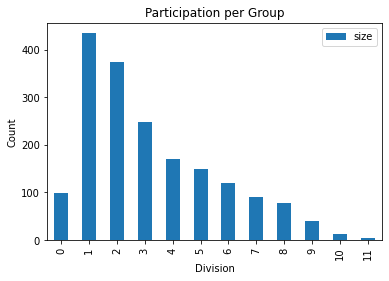

In [175]:
counts = df.groupby('Division', as_index=False).size()
counts.plot(kind='bar')
plt.xlabel('Division')
plt.ylabel('Count')
plt.title('Participation per Group')
plt.show()

#### Finish time by age group

Shows the spread of performance across age groups. 

**Result: finish times quite spread out within age groups overall**

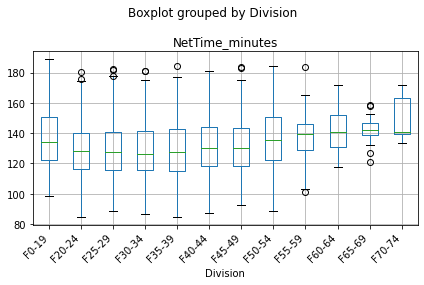

In [181]:
df.boxplot(column='NetTime_minutes', by='Division')
plt.xticks(rotation=45, ha='right') # Rotates and right-aligns labels
plt.tight_layout() 
plt.show()

#### Frequency of runners per Finish time per age group

**Result: Younger runners skew more**

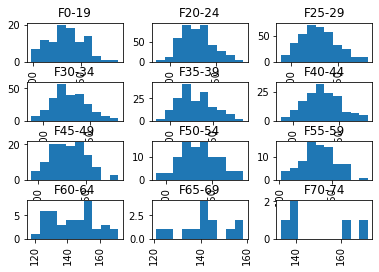

In [193]:
df.hist(column='NetTime_minutes', by='Division', layout=(4, 3))
plt.show()

#### Top 5 finishers per age group

**Result:**

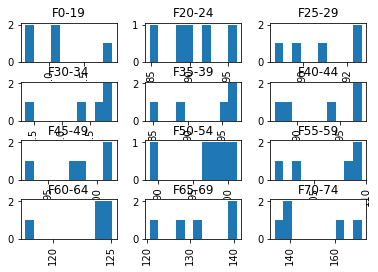

In [208]:
df_top = df.sort_values('NetTime_minutes', ascending=True).groupby('Division').head(5)
# df_top[df_top['Division'] == 'F20-24']
# g = sn.catplot(data=df_top, x='Division', y='NetTime_minutes', kind='bar', col='Division')
# plot.show()

df_top.hist(column='NetTime_minutes', by='Division', layout=(4, 3))
plt.show()

#### Normalize FInish time by age group

Normalize each runner’s time relative to others in their age group. This helps compare performance across age groups.

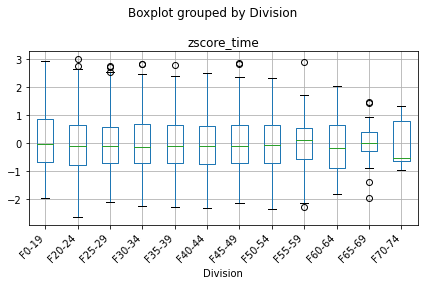

In [207]:
df['zscore_time'] = df.groupby('Division')['NetTime_minutes'].transform(lambda x: (x - x.mean()) / x.std())
df.boxplot(column='zscore_time', by='Division')
plt.xticks(rotation=45, ha='right') # Rotates and right-aligns labels
plt.tight_layout() 
plt.show()

#### Modeling

1. See if age and performance are correlated

In [210]:
correlation = df['Age'].corr(df['NetTime_minutes'])
print(f"Correlation between age and finish time: {correlation:.3f}")

Correlation between age and finish time: 0.133


#### Modeling
2. Quadratic model

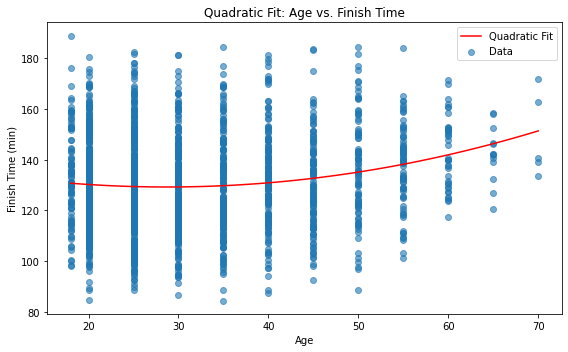

In [213]:
# Fit quadratic model: NetTime_minutes = a*Age² + b*Age + c
coeffs = np.polyfit(df['Age'], df['NetTime_minutes'], deg=2)

# Generate predicted values
age_range = np.linspace(df['Age'].min(), df['Age'].max(), 100)
predicted = np.polyval(coeffs, age_range)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(df['Age'], df['NetTime_minutes'], alpha=0.6, label='Data')
plt.plot(age_range, predicted, color='red', label='Quadratic Fit')
plt.xlabel("Age")
plt.ylabel("Finish Time (min)")
plt.title("Quadratic Fit: Age vs. Finish Time")
plt.legend()
plt.tight_layout()
plt.show()

#### Modeling

3. Multivariate regression

In [215]:
import statsmodels.api as sm

# Define features and outcome
X = df[['Age', 'Pace_minutes', '10k_minutes']]
y = df['NetTime_minutes']

# Add intercept term
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Summary of regression results
print(model.summary())


ModuleNotFoundError: No module named 'statsmodels'